<a href="https://colab.research.google.com/github/wesley0521/Deep-Learning/blob/main/Face%20Recognize%20--%20CNN%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 使用CNN模型辨識人臉情緒
# 需要先到 https://www.kaggle.com/datasets/debanga/facial-expression-recognition-challenge 下載檔案

import pandas as pd
import numpy as np
# 呼叫檔案
dataset = pd.read_csv("icml_face_data.csv")
# print(dataset.columns)
# 發現欄位名稱前面有空格
dataset.columns = list(map(lambda x:x.lstrip(),dataset.columns))
# print("處理後:",dataset.columns)

#將訓練及測試資料及分開
train_index = dataset["Usage"] == "Training"
test_index = (train_index == False)
train_data = dataset[train_index].reset_index(drop=True)
test_data = dataset[train_index].reset_index(drop=True)
train_data = train_data.drop(["Usage"],axis=1)
test_data = test_data.drop(["Usage"],axis=1)

# 處理pixels，目前為 str 形式 ，使用 split 方法
# print(type(dataset["pixels"][0]))
def pixel_img(pixel_str):
    pixel_str_split = pixel_str.split()
    # 將 split 完的 pixel 轉換為整數型態再轉乘 48×48 的矩陣
    pixel_to_img = np.array(pixel_str_split).astype(int).reshape(48,48)
    return pixel_to_img

# 定義情緒的規則
Emotion_Rule = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

# 定義一個函數來處理每一筆資料的 emotiom 和 pixes
from tqdm import tqdm
def emo_pixel_dataset(Dataset):
    emotion_list=[]
    image_list=[]
    for i in tqdm(range(len(Dataset))):
        emotion = Dataset["emotion"][i]
        pixel = Dataset["pixels"][i]
        # 將 pixel 轉換成 CNN 所需的三維矩陣
        img = pixel_img(pixel).reshape(48,48,1)
        emotion_list.append(emotion)
        image_list.append(img)
    # 將 list 轉成 np.array
    emotion_array = np.array(emotion_list)
    image_array = np.array(image_list)
    return emotion_array, image_array

# 將 train 和 test 中的 emotion 和 pixels 分開
train_emotion, train_image = emo_pixel_dataset(train_data)
test_emotion, test_image = emo_pixel_dataset(test_data)
# 將數值範圍設在 0 到 1 之間
train_image = train_image/255
test_image = test_image/255
# print(train_emotion.shape)
#=====================================================================================================================================
# 建立 CNN 模型
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Softmax
from tensorflow.keras.regularizers import l2
L2_lambda = 1e-6
Drop_proda = 0.2
CNN_model = tf.keras.models.Sequential([

    # 第一個區塊 feature map 為 48×48×1
    Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu", input_shape=(48,48,1)),
    Dropout(Drop_proda),
    Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu", kernel_regularizer=l2(L2_lambda)),
    Dropout(Drop_proda),
    Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu", kernel_regularizer=l2(L2_lambda)),
    MaxPooling2D(pool_size=(2,2), strides=(1,1)),   # 此時的 feature map 為 為 24×24×64

     # 第二個區塊
    Dropout(Drop_proda),
    Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu", kernel_regularizer=l2(L2_lambda)),
    Dropout(Drop_proda),
    Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu", kernel_regularizer=l2(L2_lambda)),
    Dropout(Drop_proda),
    Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu", kernel_regularizer=l2(L2_lambda)),
    MaxPooling2D(pool_size=(2,2), strides=(1,1)),   # 此時的 feature map 為 為 12×12×128

    # 第三個區塊
    Dropout(Drop_proda),
    Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu", kernel_regularizer=l2(L2_lambda)),
    Dropout(Drop_proda),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu", kernel_regularizer=l2(L2_lambda)),
    Dropout(Drop_proda),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu", kernel_regularizer=l2(L2_lambda)),
    MaxPooling2D(pool_size=(2,2), strides=(1,1)),

    # 將資料轉為一為向量
    Flatten(),  # 12×12×256

    # 第四個區塊
    Dropout(Drop_proda),
    Dense(units=256, activation="relu", kernel_regularizer=l2(L2_lambda)),
    Dropout(Drop_proda),
    Dense(units=128, activation="relu", kernel_regularizer=l2(L2_lambda)),
    Dropout(Drop_proda),
    Dense(units=64, activation="relu", kernel_regularizer=l2(L2_lambda)),

    # 輸出層
    Dropout(Drop_proda),
    Dense(units=7,activation="softmax")  # 多元分類的激活函數使用：softmax
])

batch_size = 256
nums_of_epoch = 40
learning_rate = 1e-3
# 設定 optimizer
optimizer_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# 設定 loss function
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
# 編譯模型
CNN_model.compile(
    loss = loss_function,
    optimizer = optimizer_adam,
    metrics = ["accuracy"]
)
# 設定 learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 20 :
        return lr
    else :
        return lr * tf.math.exp(-0.1).numpy()
callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

100%|██████████| 28709/28709 [00:30<00:00, 943.25it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [2]:
# 訓練模型
History = CNN_model.fit(
    x = train_image,
    y = train_emotion,
    validation_data = [test_image,test_emotion],
    batch_size = batch_size,
    epochs = nums_of_epoch,
    callbacks = [callback]
)

Epoch 1/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.2193 - loss: 3.4681 - val_accuracy: 0.2513 - val_loss: 1.8204 - learning_rate: 0.0010
Epoch 2/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.2510 - loss: 1.8238 - val_accuracy: 0.2513 - val_loss: 1.8176 - learning_rate: 0.0010
Epoch 3/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.2523 - loss: 1.8190 - val_accuracy: 0.2513 - val_loss: 1.8335 - learning_rate: 0.0010
Epoch 4/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.2582 - loss: 1.7867 - val_accuracy: 0.2876 - val_loss: 1.7254 - learning_rate: 0.0010
Epoch 5/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.3101 - loss: 1.7064 - val_accuracy: 0.3669 - val_loss: 1.6368 - learning_rate: 0.0010
Epoch 6/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.3630 - loss: 1.6268 - val_accuracy: 0.3707 - val_loss: 1.5931 - learning_rate: 0.0010
Epoch 7/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.3866 - loss: 1.

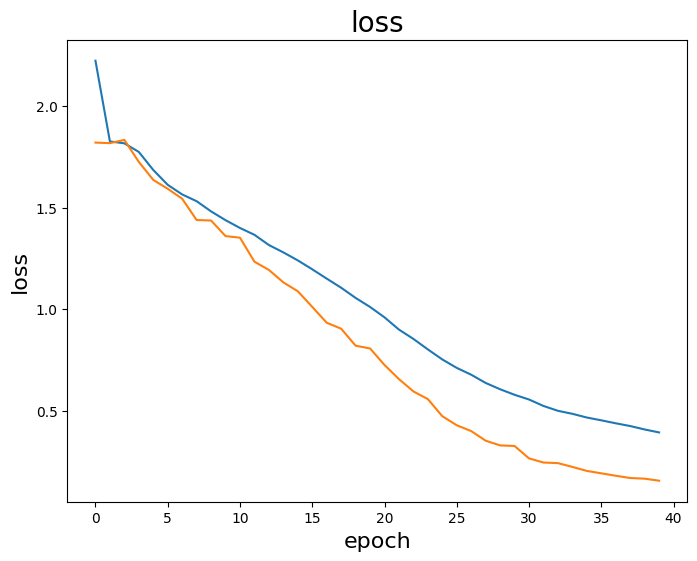

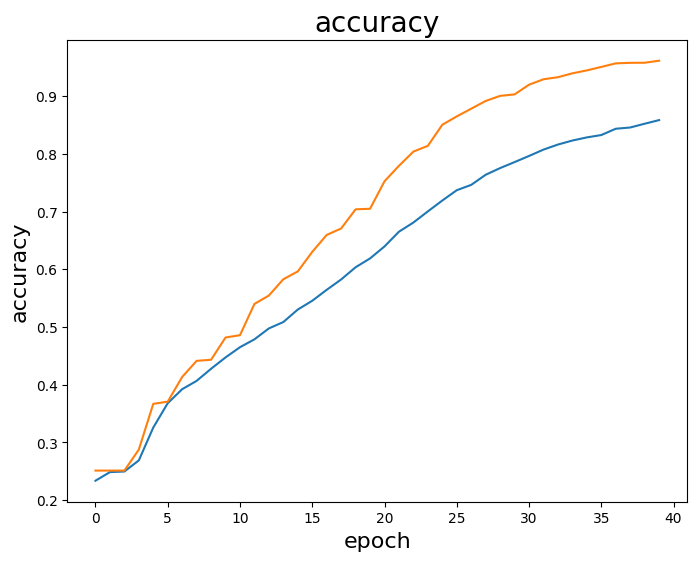

In [6]:
# 評估模型表現
loss = History.history["loss"]
accuracy = History.history["accuracy"]
val_loss = History.history["val_loss"]
val_accuracy = History.history["val_accuracy"]

# 繪製圖表
import matplotlib.pyplot as plt
# loss
plt.figure(figsize=(8,6))
plt.plot(loss, label = "train loss")
plt.plot(val_loss, label = "val loss")
plt.title("loss", fontsize = 20)
plt.xlabel("epoch" ,fontsize = 16)
plt.ylabel("loss" ,fontsize=16)
plt.show()

# accuracy
plt.figure(figsize=(8,6))
plt.plot(accuracy, label = "train accuracy")
plt.plot(val_accuracy, label = "val accuracy")
plt.title("accuracy", fontsize = 20)
plt.xlabel("epoch" ,fontsize = 16)
plt.ylabel("accuracy" ,fontsize=16)
plt.show()